## CI PFI METHOD SHUFFLING FUTURE COVARIATES


In [1]:
%tensorboard --logdir logs #Clik above this to open tensorboard!

UsageError: Line magic function `%tensorboard` not found.


In [11]:
import tensorflow as tf
import datetime, os
%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.


In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
from darts import TimeSeries
from darts.models import TFTModel
from darts.metrics import mse
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from datetime import datetime
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.model_selection import ParameterGrid
from darts.explainability import TFTExplainer

def create_output_directory(dataset_name):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = f'./HYPERPresults_{dataset_name}_{timestamp}'
    os.makedirs(output_dir, exist_ok=True)
    return output_dir

def load_data(dataset_name):
    df = pd.read_csv(f'{dataset_name}.csv')
    df['timestamp'] = pd.to_datetime(df['time_index'], unit='D', origin='2023-01-01')
    df.set_index('timestamp', inplace=True)
    df = df.drop('time_index', axis=1, errors='ignore')
    return df
    
def point_estimate_score(y_true, y_pred):
    return mse(y_true, y_pred)

def save_model(model, output_dir, target_variable):
    model_dir = os.path.join(output_dir, 'saved_models')
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, f'{target_variable}_model.pth')
    model.save(model_path)
    print(f"Model saved to {model_path}")

# Add a new function to perform hyperparameter tuning for each variable
def hyperparameter_tuning_for_all_variables(df, param_grid, num_samples, output_dir):
    results = []
    variables = df.columns.tolist()

    for target_variable in variables:
        print(f"Starting hyperparameter tuning for target variable: {target_variable}")
        covariate_variables = [var for var in variables if var != target_variable]

        best_model, best_params, best_score = hyperparameter_tuning(
            df, target_variable, covariate_variables, param_grid, num_samples
        )

        results.append({
            'target_variable': target_variable,
            'best_params': best_params,
            'best_point_score': best_score
        })

        # Optionally, save the best model for each variable
        save_model(best_model, output_dir, target_variable)

        print(f"Best params for {target_variable}: {best_params}")
        print(f"Best point score (MSE) for {target_variable}: {best_score:.4f}")
    
    return results

# The main hyperparameter tuning function for each target variable
def hyperparameter_tuning(df, target_variable, covariate_variables, param_grid, num_samples):
    best_score = float('inf')
    best_params = None
    best_model = None

    target = TimeSeries.from_series(df[target_variable].astype(np.float32))
    covariates = TimeSeries.from_dataframe(df[covariate_variables].astype(np.float32))

    train_test_split = int(0.6 * len(target))
    train_target, test_target = target[:train_test_split], target[train_test_split:]
    train_covariates, test_covariates = covariates[:train_test_split], covariates[train_test_split:]

    for params in ParameterGrid(param_grid):
        print(f"Testing parameters: {params}")
        
        model = TFTModel(
            model_name=f"TFT_tuned_{target_variable}",
            input_chunk_length=params['input_chunk_length'],
            output_chunk_length=params['output_chunk_length'],
            hidden_size=params['hidden_size'],
            lstm_layers=params['lstm_layers'],
            num_attention_heads=params['num_attention_heads'],
            batch_size=params['batch_size'],
            n_epochs=params['n_epochs'],
            add_relative_index=True,
            log_tensorboard=True,
        )

        # Train the model
        model.fit(train_target, past_covariates=train_covariates, verbose=True)

        # Make predictions
        predictions = model.predict(
            n=len(test_target),
            series=train_target,
            past_covariates=covariates,
            num_samples=num_samples
        )
        
        median_pred = predictions.quantile_timeseries(0.5)
        point_estimate_score_value = point_estimate_score(test_target, median_pred)

        # Check if the current model is better
        if point_estimate_score_value < best_score:
            best_score = point_estimate_score_value
            best_params = params
            best_model = model

        print(f"Point Estimate Score (MSE): {point_estimate_score_value:.4f}")

    print(f"Best Parameters for {target_variable}: {best_params}")
    print(f"Best Point Estimate Score for {target_variable}: {best_score:.4f}")
    
    return best_model, best_params, best_score

# Define a parameter grid for hyperparameter tuning
param_grid = {
    'input_chunk_length': [10, 15, 20, 25, 30, 40],
    'output_chunk_length': [5, 7, 10, 15, 20, 25, 30],
    'hidden_size': [32, 64, 128],
    'lstm_layers': [1, 2, 3, 4, 5],
    'num_attention_heads': [2, 4, 8, 16],
    'batch_size': [16, 32, 64],
    'n_epochs': [100, 200, 400],
}

# Call the hyperparameter tuning function in the main script
if __name__ == "__main__":
    dataset_name = "synthetic_data_harvard_0"
    num_samples = 100
    output_dir = create_output_directory(dataset_name)
    df = load_data(dataset_name)
    print(df.head())

    # Perform hyperparameter tuning for all variables
    tuning_results = hyperparameter_tuning_for_all_variables(df, param_grid, num_samples, output_dir)

    # Save the tuning results to a JSON file
    with open(os.path.join(output_dir, 'hyperparameter_tuning_results.json'), 'w') as f:
        json.dump(tuning_results, f, indent=4)
    
    print("Hyperparameter tuning completed for all variables.")


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


                  V1        V2        V3        V4
timestamp                                         
2023-01-01  0.188713 -0.700368 -3.666094  0.226284
2023-01-02  0.240496  0.707094 -1.074562  1.786855
2023-01-03 -0.995252 -0.768571 -0.377442  0.364459
2023-01-04 -0.395351  1.372412 -0.253002  0.123389
2023-01-05 -0.412162 -0.719210 -0.801287  0.118931
Starting hyperparameter tuning for target variable: V1
Testing parameters: {'batch_size': 16, 'hidden_size': 32, 'input_chunk_length': 10, 'lstm_layers': 1, 'n_epochs': 100, 'num_attention_heads': 2, 'output_chunk_length': 5}



   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 5.0 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 896    | train
6  | static_context_grn                | _GatedResidualNetwork            | 4.3 K  | train
7  | static_context_hidden_encoder_grn | _GatedResidualNetwork            | 4.3 K  | train
8  | static_context_cell_encoder_grn   | _GatedResidualNetwork            | 4.3 K  

Epoch 0:   0%|          | 0/150 [00:00<?, ?it/s] 

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 8.8 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 1.6 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K | train
7  | static_context_hidden_encoder_grn | _GatedResidualNetw

Processing target variable: V1
Epoch 1: 100%|██████████| 112/112 [00:12<00:00,  9.17it/s, v_num=logs, train_loss=2.770]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 112/112 [00:12<00:00,  9.17it/s, v_num=logs, train_loss=2.770]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.00it/s]


<Figure size 1200x800 with 0 Axes>

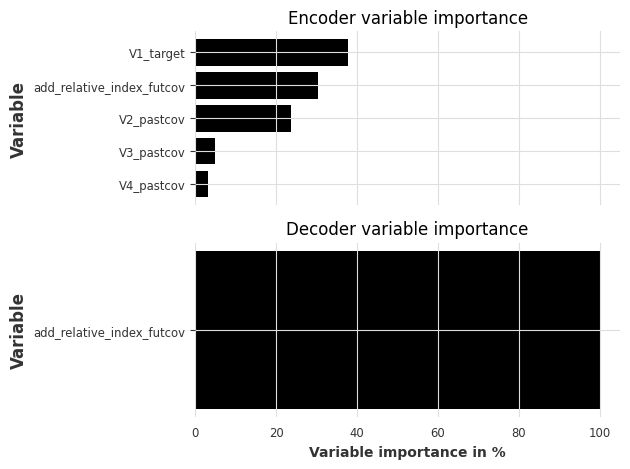

<Figure size 1200x800 with 0 Axes>

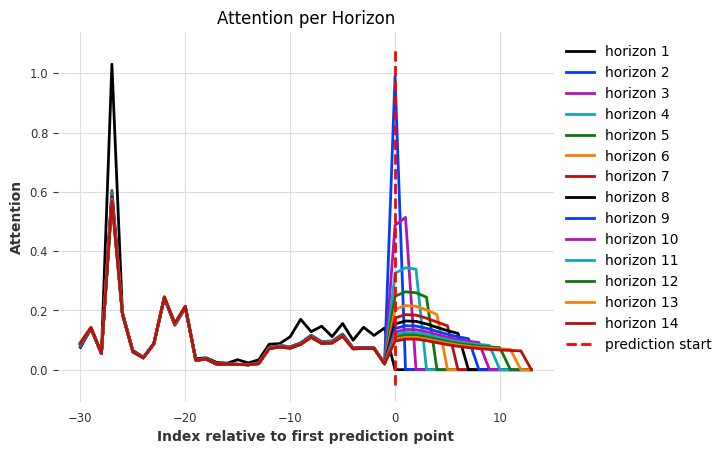

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.38it/s]


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.38it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Shuffled V2: interval_score = 0.27392949986085285, point_score = 1.0593364822565294
Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.39it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Shuffled V3: interval_score = 0.29139043116122465, point_score = 1.0150624192742652
Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.38it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 8.8 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 1.6 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K | train
7  | static_context_hidden_encoder_grn | _GatedResidualNetw


Shuffled V4: interval_score = 0.27726481403633935, point_score = 1.051855823658982
Processing target variable: V2
Epoch 1: 100%|██████████| 112/112 [00:12<00:00,  9.00it/s, v_num=logs, train_loss=2.420]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 112/112 [00:12<00:00,  9.00it/s, v_num=logs, train_loss=2.420]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 27.80it/s]


<Figure size 1200x800 with 0 Axes>

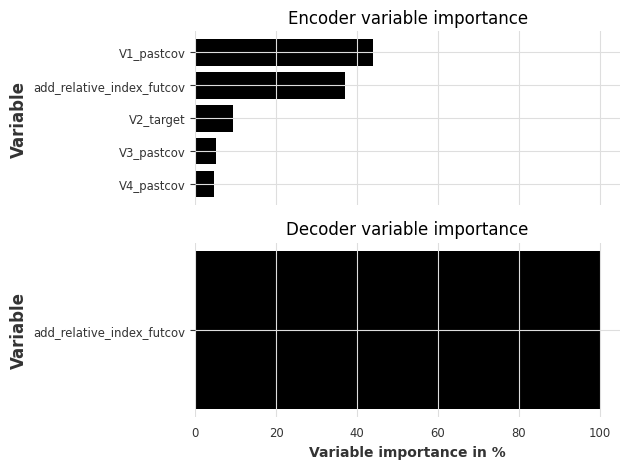

<Figure size 1200x800 with 0 Axes>

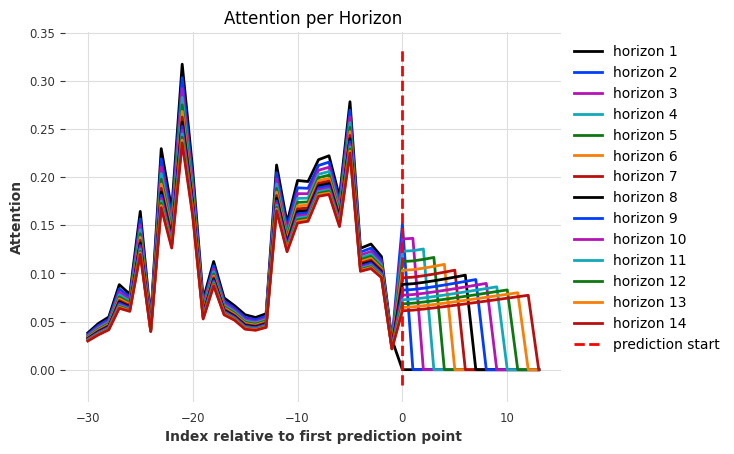

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.37it/s]


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.38it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Shuffled V1: interval_score = 0.4474058311782776, point_score = 0.7243028289122904
Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.38it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Shuffled V3: interval_score = 0.4968150448180735, point_score = 0.6232013588740822
Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.39it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 8.8 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 1.6 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K | train
7  | static_context_hidden_encoder_grn | _GatedResidualNetw


Shuffled V4: interval_score = 0.5084074232675134, point_score = 0.612766793741811
Processing target variable: V3
Epoch 1: 100%|██████████| 112/112 [00:12<00:00,  9.06it/s, v_num=logs, train_loss=2.090]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 112/112 [00:12<00:00,  9.06it/s, v_num=logs, train_loss=2.090]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.54it/s]


<Figure size 1200x800 with 0 Axes>

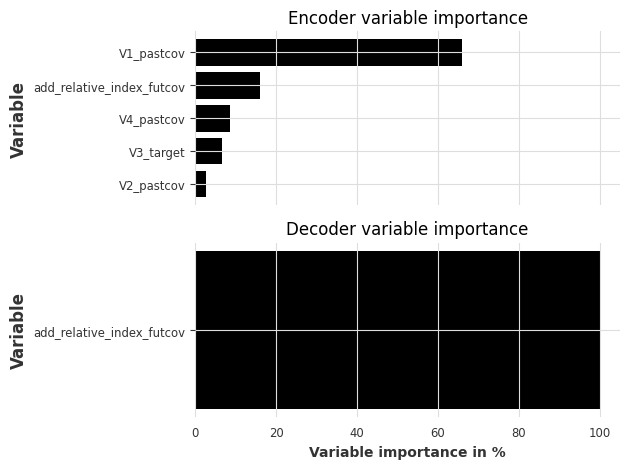

<Figure size 1200x800 with 0 Axes>

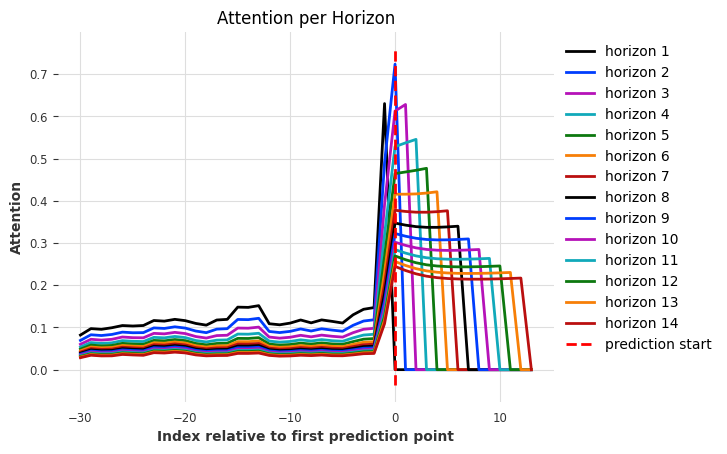

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.38it/s]


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.38it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Shuffled V1: interval_score = 0.3742723129795864, point_score = 0.7293181188232682
Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.37it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Shuffled V2: interval_score = 0.49187305962091765, point_score = 0.5094700192825935
Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.37it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 8.8 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 1.6 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K | train
7  | static_context_hidden_encoder_grn | _GatedResidualNetw


Shuffled V4: interval_score = 0.4983252572440309, point_score = 0.50676208659277
Processing target variable: V4
Epoch 1: 100%|██████████| 112/112 [00:12<00:00,  9.13it/s, v_num=logs, train_loss=1.350]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 112/112 [00:12<00:00,  9.13it/s, v_num=logs, train_loss=1.350]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 26.60it/s]


<Figure size 1200x800 with 0 Axes>

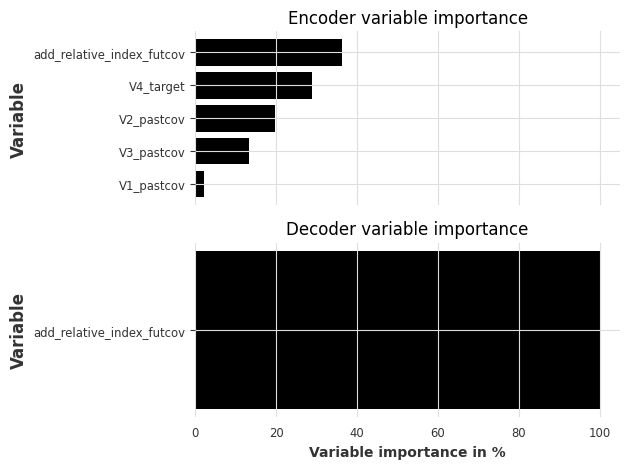

<Figure size 1200x800 with 0 Axes>

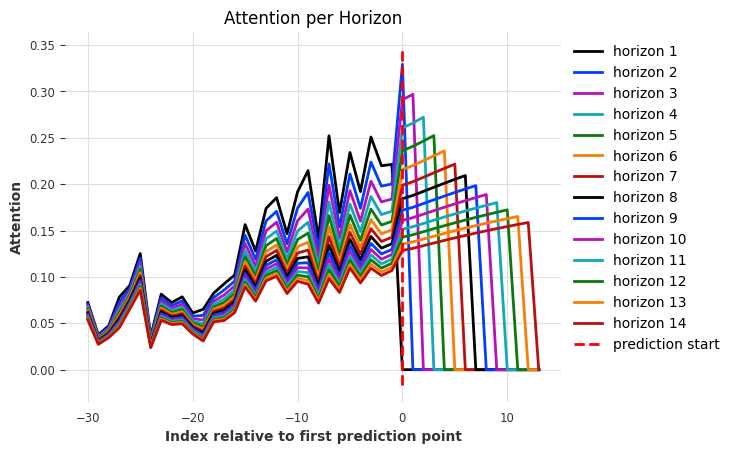

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.37it/s]


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.38it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Shuffled V1: interval_score = 0.6145708131110063, point_score = 0.20671001076720075
Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.38it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Shuffled V2: interval_score = 0.6216112513130763, point_score = 0.21257359895270383
Predicting DataLoader 0: 100%|██████████| 1/1 [00:02<00:00,  0.37it/s]
Shuffled V3: interval_score = 0.6149563548001693, point_score = 0.20989131554919915
All results and plots saved in: ./results_synthetic_data_harvard_0_20240927_131620


In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from darts import TimeSeries
from darts.models import TFTModel
from darts.metrics import mse
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from datetime import datetime
from matplotlib.backends.backend_pdf import PdfPages
from darts.explainability import TFTExplainer

def create_output_directory(dataset_name):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = f'./results_{dataset_name}_{timestamp}'
    os.makedirs(output_dir, exist_ok=True)
    return output_dir

def load_data(dataset_name):
    df = pd.read_csv(f'{dataset_name}.csv')
    df['timestamp'] = pd.to_datetime(df['time_index'], unit='D', origin='2023-01-01')
    df.set_index('timestamp', inplace=True)
    df = df.drop('time_index', axis=1, errors='ignore')
    return df

def shuffle_covariate(covariates, column_name):
    shuffled_covariates = covariates.copy()
    values = shuffled_covariates.values()
    column_index = list(covariates.columns).index(column_name)
    np.random.shuffle(values[:, column_index])
    shuffled_df = pd.DataFrame(
        values,
        columns=covariates.columns,
        index=covariates.time_index
    )
    return TimeSeries.from_dataframe(shuffled_df)

def point_estimate_score(y_true, y_pred):
    return mse(y_true, y_pred)

def interval_score(y_true, y_pred_lower, y_pred_upper, alpha=0.2):
    y_true_values = y_true.values()
    lower_values = y_pred_lower.values()
    upper_values = y_pred_upper.values()
    
    coverage = np.mean((y_true_values >= lower_values) & (y_true_values <= upper_values))
    width = np.mean(upper_values - lower_values)
    return coverage - alpha * width

def create_model(target_variable):
    return TFTModel(
        model_name=f"TFT_dataset0_{target_variable}",
        input_chunk_length=30,
        output_chunk_length=14,
        hidden_size=64,
        lstm_layers=2,
        num_attention_heads=4,
        batch_size=32,
        n_epochs=2,
        add_relative_index=True,
        log_tensorboard=True,
    )

def save_model(model, output_dir, target_variable):
    model_dir = os.path.join(output_dir, 'saved_models')
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, f'{target_variable}_model.pth')
    model.save(model_path)
    print(f"Model saved to {model_path}")


def train_and_evaluate(target_variable, covariate_variables, df, num_samples, output_dir):
    target = TimeSeries.from_series(df[target_variable].astype(np.float32))
    covariates = TimeSeries.from_dataframe(df[covariate_variables].astype(np.float32))

    train_test_split = int(0.9 * len(target))
    train_target, test_target = target[:train_test_split], target[train_test_split:]
    train_covariates, test_covariates = covariates[:train_test_split], covariates[train_test_split:]

    model = create_model(target_variable)
    model.fit(train_target, past_covariates=train_covariates, verbose=True)

    # Save the trained model
    #save_model(model, output_dir, target_variable)
    
    # Generate and save explainability plots
    save_explainability_plots(model, output_dir, target_variable)

    predictions = model.predict(
        n=len(test_target),
        series=train_target,
        past_covariates=covariates,
        num_samples=num_samples
    )
    
    lower_pred = predictions.quantile_timeseries(0.1)
    median_pred = predictions.quantile_timeseries(0.5)
    upper_pred = predictions.quantile_timeseries(0.9)
    
    interval_score_value = interval_score(test_target, lower_pred, upper_pred)
    point_estimate_score_value = point_estimate_score(test_target, median_pred)
    
    # Generate and save prediction plots
    plot_and_save_predictions(test_target, predictions, point_estimate_score_value, output_dir, target_variable)
    
    return model, interval_score_value, point_estimate_score_value, train_target, test_target, covariates, train_test_split

def run_pfi_analysis(df, num_samples, output_dir):
    variables = df.columns.tolist()
    results = []

    for target_variable in variables:
        print(f"Processing target variable: {target_variable}")
        covariate_variables = [var for var in variables if var != target_variable]

        model, real_interval_score, real_point_score, train_target, test_target, covariates, train_test_split = train_and_evaluate(
            target_variable, covariate_variables, df, num_samples, output_dir
        )
        

        shuffle_interval_scores = {}
        shuffle_point_scores = {}
        for covariate in covariate_variables:
            shuffled_covariates = shuffle_covariate(covariates, covariate)
            shuffled_predictions = model.predict(
                n=len(test_target),
                series=train_target,
                past_covariates=shuffled_covariates,
                num_samples=num_samples
            )
            
            lower_pred = shuffled_predictions.quantile_timeseries(0.1)
            median_pred = shuffled_predictions.quantile_timeseries(0.5)
            upper_pred = shuffled_predictions.quantile_timeseries(0.9)
            
            shuffled_interval_score = interval_score(test_target, lower_pred, upper_pred)
            shuffled_point_score = point_estimate_score(test_target, median_pred)
            
            shuffle_interval_scores[covariate] = shuffled_interval_score
            shuffle_point_scores[covariate] = shuffled_point_score

            print(f"Shuffled {covariate}: interval_score = {shuffled_interval_score}, point_score = {shuffled_point_score}")

        results.append({
            'target': target_variable,
            'real_interval_score': real_interval_score,
            'real_point_score': real_point_score,
            'shuffle_interval_scores': shuffle_interval_scores,
            'shuffle_point_scores': shuffle_point_scores
        })

    return results


def save_results(results, output_dir, dataset_name):
    with open(os.path.join(output_dir, f'{dataset_name}_interval_scores.json'), 'w') as f:
        json.dump(results, f, indent=2)

def load_results(output_dir, dataset_name):
    with open(os.path.join(output_dir, f'{dataset_name}_interval_scores.json'), 'r') as f:
        return json.load(f)

def prepare_visualization_data(results):
    variables = [result['target'] for result in results]
    n_vars = len(variables)
    
    interval_scores_before = np.array([result['real_interval_score'] for result in results])
    point_scores_before = np.array([result['real_point_score'] for result in results])
    
    interval_scores_after = np.full((n_vars, n_vars), np.nan)
    point_scores_after = np.full((n_vars, n_vars), np.nan)

    for i, result in enumerate(results):
        for j, var in enumerate(variables):
            if var in result['shuffle_interval_scores']:
                interval_scores_after[i, j] = result['shuffle_interval_scores'][var]
                point_scores_after[i, j] = result['shuffle_point_scores'][var]

    interval_pfi_ratios = interval_scores_before[:, np.newaxis] / interval_scores_after
    point_pfi_ratios = point_scores_before[:, np.newaxis] / point_scores_after
    
    return variables, interval_scores_before, interval_scores_after, point_scores_before, point_scores_after, interval_pfi_ratios, point_pfi_ratios

def plot_and_save_predictions(test_target, predictions, point_estimate_score_value, output_dir, target_variable):
    plt.figure(figsize=(12, 6))
    test_target.plot(label="Actual")
    predictions.plot(label="Forecast")
    median_pred = predictions.quantile_timeseries(0.5)
    median_pred.plot(label="Forecast (quantile 0.5)")
    plt.title(f"TFT Forecast vs Actual for {target_variable}\nMSE: {point_estimate_score_value:.4f}")
    plt.legend()
    plt.tight_layout()
    save_plot(plt.gcf(), output_dir, f"{target_variable}_predictions.png")
    plt.close()

def save_plot(fig, output_dir, filename):
    plt.savefig(os.path.join(output_dir, filename), bbox_inches='tight')
    plt.close(fig)


def plot_interval_scores(variables, scores_before, scores_after, output_dir):
    colors = plt.cm.rainbow(np.linspace(0, 1, len(variables)))
    fig, ax = plt.subplots(figsize=(14, 8))

    for i, (target, real_score) in enumerate(zip(variables, scores_before)):
        color = colors[i]
        for shuffled_score in scores_after[i]:
            if not np.isnan(shuffled_score):
                ax.plot([1, 2], [real_score, shuffled_score], '-', color=color)
                ax.scatter([1, 2], [real_score, shuffled_score], color=color, s=100, zorder=5)
        ax.text(0.9, real_score, target, ha='right', va='center', fontsize=12, fontweight='bold')

    ax.set_xlim(0.5, 2.5)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Before permutation', 'After permutation'], fontsize=12)
    ax.set_ylabel('Interval Score', fontsize=12)
    ax.set_title('(a) Interval scores before and after permutation', fontsize=14)
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    save_plot(fig, output_dir, 'interval_scores.png')

def plot_point_scores(variables, scores_before, scores_after, output_dir):
    colors = plt.cm.rainbow(np.linspace(0, 1, len(variables)))
    fig, ax = plt.subplots(figsize=(14, 8))

    for i, (target, real_score) in enumerate(zip(variables, scores_before)):
        color = colors[i]
        for shuffled_score in scores_after[i]:
            if not np.isnan(shuffled_score):
                ax.plot([1, 2], [real_score, shuffled_score], '-', color=color)
                ax.scatter([1, 2], [real_score, shuffled_score], color=color, s=100, zorder=5)
        ax.text(0.9, real_score, target, ha='right', va='center', fontsize=12, fontweight='bold')

    ax.set_xlim(0.5, 2.5)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Before permutation', 'After permutation'], fontsize=12)
    ax.set_ylabel('Point Estimate Score (MSE)', fontsize=12)
    ax.set_title('(a) Point estimate scores before and after permutation', fontsize=14)
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    save_plot(fig, output_dir, 'point_estimate_scores.png')

def plot_pfi_ratios(variables, pfi_ratios, score_type, output_dir):
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(pfi_ratios, annot=True, fmt='.3f', cmap='YlGnBu', ax=ax, vmin=0, vmax=2,
                xticklabels=variables, yticklabels=variables)
    ax.set_title(f'(b) PFI ratio between variables ({score_type})', fontsize=14)
    ax.set_xticklabels(variables, rotation=45, ha='right', fontsize=12, fontweight='bold')
    ax.set_yticklabels(variables, rotation=0, fontsize=12, fontweight='bold')
    plt.tight_layout()
    save_plot(fig, output_dir, f'pfi_ratios_{score_type.lower().replace(" ", "_")}.png')

def plot_adjacency_matrix(variables, pfi_ratios, score_type, output_dir, threshold=0.8):
    adjacency_matrix = (pfi_ratios < threshold).astype(int)
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(adjacency_matrix, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=variables, yticklabels=variables)
    ax.set_title(f'(c) Final adjacency matrix based on {score_type} PFI', fontsize=14)
    ax.set_xticklabels(variables, rotation=45, ha='right', fontsize=12, fontweight='bold')
    ax.set_yticklabels(variables, rotation=0, fontsize=12, fontweight='bold')
    plt.tight_layout()
    save_plot(fig, output_dir, f'adjacency_matrix_{score_type.lower().replace(" ", "_")}.png')

def save_explainability_plots(model, output_dir, target_variable):
    explainer = TFTExplainer(model)
    explainability_result = explainer.explain()
    
    # Variable selection plot
    plt.figure(figsize=(12, 8))
    explainer.plot_variable_selection(explainability_result)
    plt.title(f"Variable Selection for {target_variable}")
    plt.tight_layout()
    save_plot(plt.gcf(), output_dir, f"{target_variable}_variable_selection.png")
    
    # Attention plot
    plt.figure(figsize=(12, 8))
    explainer.plot_attention(explainability_result)
    plt.title(f"Attention Plot for {target_variable}")
    plt.tight_layout()
    save_plot(plt.gcf(), output_dir, f"{target_variable}_attention.png")

def save_all_plots_to_pdf(output_dir, dataset_name):
    pdf_path = os.path.join(output_dir, f'{dataset_name}_all_plots.pdf')
    with PdfPages(pdf_path) as pdf:
        for filename in os.listdir(output_dir):
            if filename.endswith('.png'):
                fig = plt.figure(figsize=(10, 8))
                img = plt.imread(os.path.join(output_dir, filename))
                plt.imshow(img)
                plt.axis('off')
                plt.title(filename.replace('.png', '').replace('_', ' '))
                pdf.savefig(fig, bbox_inches='tight')
                plt.close(fig)

def main(dataset_name, num_samples):
    output_dir = create_output_directory(dataset_name)
    df = load_data(dataset_name)
    results = run_pfi_analysis(df, num_samples, output_dir)
    save_results(results, output_dir, dataset_name)
    
    results = load_results(output_dir, dataset_name)
    variables, interval_scores_before, interval_scores_after, point_scores_before, point_scores_after, interval_pfi_ratios, point_pfi_ratios = prepare_visualization_data(results)
    
    plot_interval_scores(variables, interval_scores_before, interval_scores_after, output_dir)
    plot_point_scores(variables, point_scores_before, point_scores_after, output_dir)
    plot_pfi_ratios(variables, interval_pfi_ratios, "Interval Score", output_dir)
    plot_pfi_ratios(variables, point_pfi_ratios, "Point Estimate Score", output_dir)
    plot_adjacency_matrix(variables, interval_pfi_ratios, "Interval Score", output_dir)
    plot_adjacency_matrix(variables, point_pfi_ratios, "Point Estimate Score", output_dir)
    
    save_all_plots_to_pdf(output_dir, dataset_name)
    
    print(f"All results and plots saved in: {output_dir}")

if __name__ == "__main__":
    dataset_name = "synthetic_data_harvard_0"
    num_samples = 100
    main(dataset_name, num_samples)

In [3]:
import os

# get the current working directory
current_working_directory = os.getcwd()

# print output to the console
print(current_working_directory)

/Users/florisschouw/Documents/master_thesis_v2/PFI METHODS


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Processing target variable: Boerenkaas



   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 7.0 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 1.6 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K | train
7  | static_context_hidden_encoder_grn | _GatedResidualNetwork            | 16.8 K | train
8  | static_context_cell_encoder_grn   | _GatedResidualNetwork            | 16.8 K 

Epoch 399: 100%|██████████| 4/4 [00:00<00:00, 13.87it/s, v_num=logs, train_loss=0.204]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 4/4 [00:00<00:00, 13.73it/s, v_num=logs, train_loss=0.204]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  0.59it/s]


<Figure size 1200x800 with 0 Axes>

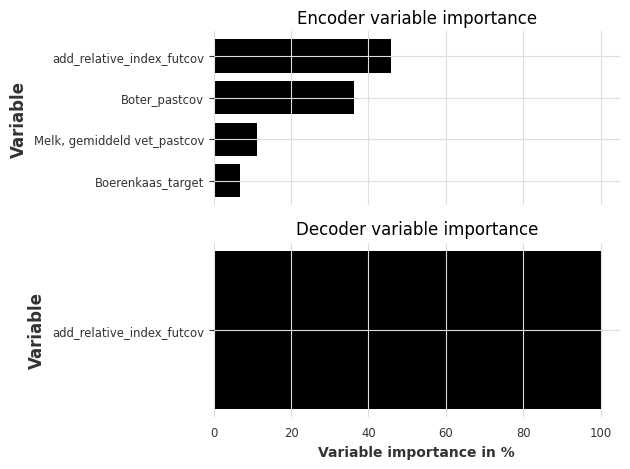

<Figure size 1200x800 with 0 Axes>

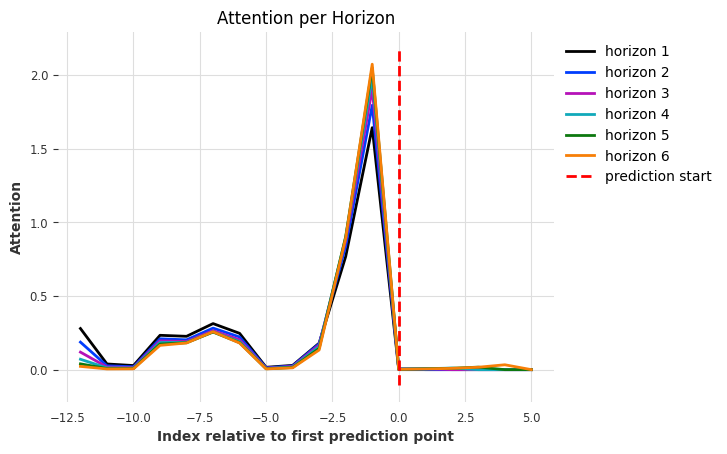

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  0.61it/s]


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Shuffled Boter: interval_score = -0.028897532172825036, point_score = 0.3627456495655331
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 7.0 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 1.6 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K | train
7  | static_context_hidden_encoder_grn | _GatedResidualNetw


Shuffled Melk, gemiddeld vet: interval_score = -0.019744569322337285, point_score = 0.38785866928253454
Processing target variable: Boter
Epoch 399: 100%|██████████| 4/4 [00:00<00:00, 15.83it/s, v_num=logs, train_loss=0.273]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 4/4 [00:00<00:00, 15.71it/s, v_num=logs, train_loss=0.273]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.04it/s]


<Figure size 1200x800 with 0 Axes>

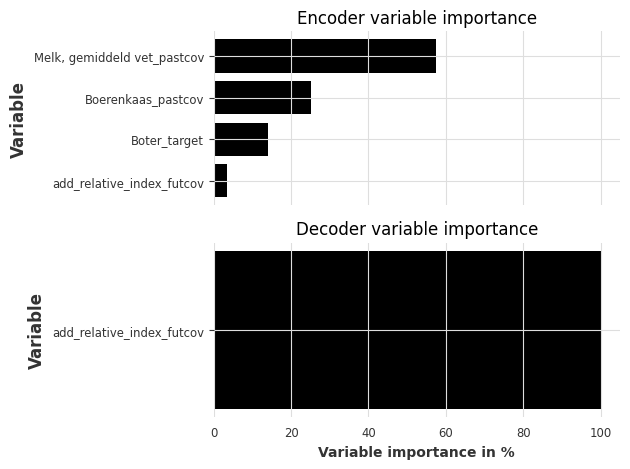

<Figure size 1200x800 with 0 Axes>

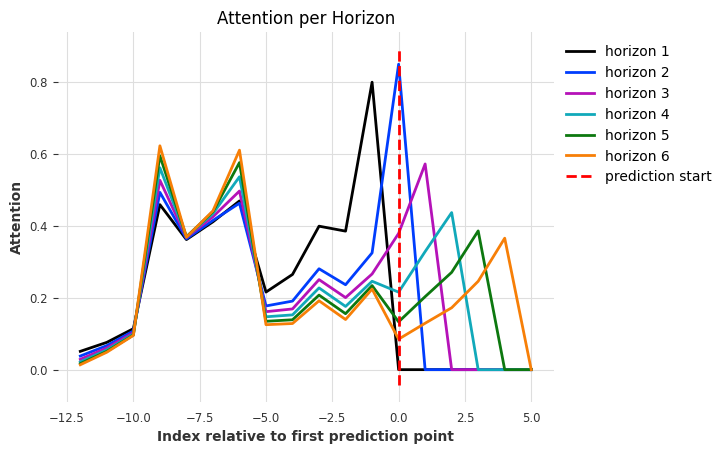

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Shuffled Boerenkaas: interval_score = 0.03016094083371368, point_score = 1.6705712913728092
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 7.0 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 1.6 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 16.8 K | train
7  | static_context_hidden_encoder_grn | _GatedResidualNetw


Shuffled Melk, gemiddeld vet: interval_score = 0.06727442751760067, point_score = 1.5568341561015593
Processing target variable: Melk, gemiddeld vet
Epoch 399: 100%|██████████| 4/4 [00:00<00:00,  4.68it/s, v_num=logs, train_loss=0.277]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 4/4 [00:00<00:00,  4.67it/s, v_num=logs, train_loss=0.277]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]


<Figure size 1200x800 with 0 Axes>

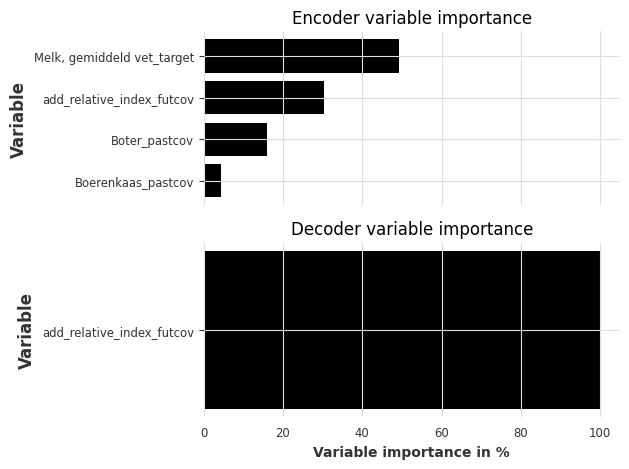

<Figure size 1200x800 with 0 Axes>

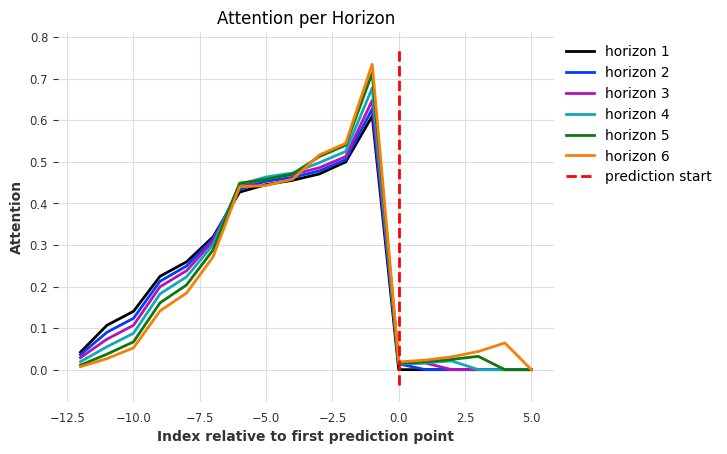

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  0.98it/s]


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Shuffled Boerenkaas: interval_score = 0.24187232872714168, point_score = 0.19033816406700596
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]
Shuffled Boter: interval_score = 0.11613855999449023, point_score = 0.4169206347338131
All results and plots saved in: ./results_output_melk_reversed_20240928_185831


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from darts import TimeSeries
from darts.models import TFTModel
from darts.metrics import mse
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from datetime import datetime
from matplotlib.backends.backend_pdf import PdfPages
from darts.explainability import TFTExplainer

def create_output_directory(dataset_name):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = f'./results_{dataset_name}_{timestamp}'
    os.makedirs(output_dir, exist_ok=True)
    return output_dir

def load_data(dataset_name):
    df = pd.read_csv(f'{dataset_name}.csv')
    df['timestamp'] = pd.to_datetime(df['time_index'], unit='D', origin='2023-01-01')
    df.set_index('timestamp', inplace=True)
    df = df.drop('time_index', axis=1, errors='ignore')
    return df

def shuffle_covariate(covariates, column_name):
    shuffled_covariates = covariates.copy()
    values = shuffled_covariates.values()
    column_index = list(covariates.columns).index(column_name)
    np.random.shuffle(values[:, column_index])
    shuffled_df = pd.DataFrame(
        values,
        columns=covariates.columns,
        index=covariates.time_index
    )
    return TimeSeries.from_dataframe(shuffled_df)

def point_estimate_score(y_true, y_pred):
    return mse(y_true, y_pred)

def interval_score(y_true, y_pred_lower, y_pred_upper, alpha=0.2):
    y_true_values = y_true.values()
    lower_values = y_pred_lower.values()
    upper_values = y_pred_upper.values()
    
    coverage = np.mean((y_true_values >= lower_values) & (y_true_values <= upper_values))
    width = np.mean(upper_values - lower_values)
    return coverage - alpha * width

def create_model(target_variable):
    return TFTModel(
        model_name= f"TFT_dataset_milk_{target_variable}",
        input_chunk_length=12,
        output_chunk_length=6,
        hidden_size=64,
        lstm_layers=2,
        num_attention_heads=4,
        batch_size=32,
        n_epochs=400,
        add_relative_index=True,
        log_tensorboard=True,
    )

def save_model(model, output_dir, target_variable):
    model_dir = os.path.join(output_dir, 'saved_models')
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, f'{target_variable}_model.pth')
    model.save(model_path)
    print(f"Model saved to {model_path}")


def train_and_evaluate(target_variable, covariate_variables, df, num_samples, output_dir):
    target = TimeSeries.from_series(df[target_variable].astype(np.float32))
    covariates = TimeSeries.from_dataframe(df[covariate_variables].astype(np.float32))

    train_test_split = int(0.6 * len(target))
    train_target, test_target = target[:train_test_split], target[train_test_split:]
    train_covariates, test_covariates = covariates[:train_test_split], covariates[train_test_split:]

    model = create_model(target_variable)


    
    model.fit(train_target, past_covariates=train_covariates, verbose=True)
    # Save the trained model
    #save_model(model, output_dir, target_variable)
    
    # Generate and save explainability plots
    save_explainability_plots(model, output_dir, target_variable)

    predictions = model.predict(
        n=len(test_target),
        series=train_target,
        past_covariates=covariates,
        num_samples=num_samples
    )
    
    lower_pred = predictions.quantile_timeseries(0.1)
    median_pred = predictions.quantile_timeseries(0.5)
    upper_pred = predictions.quantile_timeseries(0.9)
    
    interval_score_value = interval_score(test_target, lower_pred, upper_pred)
    point_estimate_score_value = point_estimate_score(test_target, median_pred)
    
    # Generate and save prediction plots
    plot_and_save_predictions(test_target, predictions, point_estimate_score_value, output_dir, target_variable)
    
    return model, interval_score_value, point_estimate_score_value, train_target, test_target, covariates, train_test_split

def run_pfi_analysis(df, num_samples, output_dir):
    variables = df.columns.tolist()
    results = []

    for target_variable in variables:
        print(f"Processing target variable: {target_variable}")
        covariate_variables = [var for var in variables if var != target_variable]

        model, real_interval_score, real_point_score, train_target, test_target, covariates, train_test_split = train_and_evaluate(
            target_variable, covariate_variables, df, num_samples, output_dir
        )
        

        shuffle_interval_scores = {}
        shuffle_point_scores = {}
        for covariate in covariate_variables:
            shuffled_covariates = shuffle_covariate(covariates, covariate)
            shuffled_predictions = model.predict(
                n=len(test_target),
                series=train_target,
                past_covariates=shuffled_covariates,
                num_samples=num_samples
            )
            
            lower_pred = shuffled_predictions.quantile_timeseries(0.1)
            median_pred = shuffled_predictions.quantile_timeseries(0.5)
            upper_pred = shuffled_predictions.quantile_timeseries(0.9)
            
            shuffled_interval_score = interval_score(test_target, lower_pred, upper_pred)
            shuffled_point_score = point_estimate_score(test_target, median_pred)
            
            shuffle_interval_scores[covariate] = shuffled_interval_score
            shuffle_point_scores[covariate] = shuffled_point_score

            print(f"Shuffled {covariate}: interval_score = {shuffled_interval_score}, point_score = {shuffled_point_score}")

        results.append({
            'target': target_variable,
            'real_interval_score': real_interval_score,
            'real_point_score': real_point_score,
            'shuffle_interval_scores': shuffle_interval_scores,
            'shuffle_point_scores': shuffle_point_scores
        })

    return results


def save_results(results, output_dir, dataset_name):
    with open(os.path.join(output_dir, f'{dataset_name}_interval_scores.json'), 'w') as f:
        json.dump(results, f, indent=2)

def load_results(output_dir, dataset_name):
    with open(os.path.join(output_dir, f'{dataset_name}_interval_scores.json'), 'r') as f:
        return json.load(f)

def prepare_visualization_data(results):
    variables = [result['target'] for result in results]
    n_vars = len(variables)
    
    interval_scores_before = np.array([result['real_interval_score'] for result in results])
    point_scores_before = np.array([result['real_point_score'] for result in results])
    
    interval_scores_after = np.full((n_vars, n_vars), np.nan)
    point_scores_after = np.full((n_vars, n_vars), np.nan)

    for i, result in enumerate(results):
        for j, var in enumerate(variables):
            if var in result['shuffle_interval_scores']:
                interval_scores_after[i, j] = result['shuffle_interval_scores'][var]
                point_scores_after[i, j] = result['shuffle_point_scores'][var]

    interval_pfi_ratios = interval_scores_before[:, np.newaxis] / interval_scores_after
    point_pfi_ratios = point_scores_before[:, np.newaxis] / point_scores_after
    
    return variables, interval_scores_before, interval_scores_after, point_scores_before, point_scores_after, interval_pfi_ratios, point_pfi_ratios

def plot_and_save_predictions(test_target, predictions, point_estimate_score_value, output_dir, target_variable):
    plt.figure(figsize=(12, 6))
    test_target.plot(label="Actual")
    predictions.plot(label="Forecast")
    median_pred = predictions.quantile_timeseries(0.5)
    median_pred.plot(label="Forecast (quantile 0.5)")
    plt.title(f"TFT Forecast vs Actual for {target_variable}\nMSE: {point_estimate_score_value:.4f}")
    plt.legend()
    plt.tight_layout()
    save_plot(plt.gcf(), output_dir, f"{target_variable}_predictions.png")
    plt.close()

def save_plot(fig, output_dir, filename):
    plt.savefig(os.path.join(output_dir, filename), bbox_inches='tight')
    plt.close(fig)


def plot_interval_scores(variables, scores_before, scores_after, output_dir):
    colors = plt.cm.rainbow(np.linspace(0, 1, len(variables)))
    fig, ax = plt.subplots(figsize=(14, 8))

    for i, (target, real_score) in enumerate(zip(variables, scores_before)):
        color = colors[i]
        for shuffled_score in scores_after[i]:
            if not np.isnan(shuffled_score):
                ax.plot([1, 2], [real_score, shuffled_score], '-', color=color)
                ax.scatter([1, 2], [real_score, shuffled_score], color=color, s=100, zorder=5)
        ax.text(0.9, real_score, target, ha='right', va='center', fontsize=12, fontweight='bold')

    ax.set_xlim(0.5, 2.5)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Before permutation', 'After permutation'], fontsize=12)
    ax.set_ylabel('Interval Score', fontsize=12)
    ax.set_title('(a) Interval scores before and after permutation', fontsize=14)
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    save_plot(fig, output_dir, 'interval_scores.png')

def plot_point_scores(variables, scores_before, scores_after, output_dir):
    colors = plt.cm.rainbow(np.linspace(0, 1, len(variables)))
    fig, ax = plt.subplots(figsize=(14, 8))

    for i, (target, real_score) in enumerate(zip(variables, scores_before)):
        color = colors[i]
        for shuffled_score in scores_after[i]:
            if not np.isnan(shuffled_score):
                ax.plot([1, 2], [real_score, shuffled_score], '-', color=color)
                ax.scatter([1, 2], [real_score, shuffled_score], color=color, s=100, zorder=5)
        ax.text(0.9, real_score, target, ha='right', va='center', fontsize=12, fontweight='bold')

    ax.set_xlim(0.5, 2.5)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Before permutation', 'After permutation'], fontsize=12)
    ax.set_ylabel('Point Estimate Score (MSE)', fontsize=12)
    ax.set_title('(a) Point estimate scores before and after permutation', fontsize=14)
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    save_plot(fig, output_dir, 'point_estimate_scores.png')

def plot_pfi_ratios(variables, pfi_ratios, score_type, output_dir):
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(pfi_ratios, annot=True, fmt='.3f', cmap='YlGnBu', ax=ax, vmin=0, vmax=2,
                xticklabels=variables, yticklabels=variables)
    ax.set_title(f'(b) PFI ratio between variables ({score_type})', fontsize=14)
    ax.set_xticklabels(variables, rotation=45, ha='right', fontsize=12, fontweight='bold')
    ax.set_yticklabels(variables, rotation=0, fontsize=12, fontweight='bold')
    plt.tight_layout()
    save_plot(fig, output_dir, f'pfi_ratios_{score_type.lower().replace(" ", "_")}.png')

def plot_adjacency_matrix(variables, pfi_ratios, score_type, output_dir, threshold=0.8):
    adjacency_matrix = (pfi_ratios < threshold).astype(int)
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(adjacency_matrix, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=variables, yticklabels=variables)
    ax.set_title(f'(c) Final adjacency matrix based on {score_type} PFI', fontsize=14)
    ax.set_xticklabels(variables, rotation=45, ha='right', fontsize=12, fontweight='bold')
    ax.set_yticklabels(variables, rotation=0, fontsize=12, fontweight='bold')
    plt.tight_layout()
    save_plot(fig, output_dir, f'adjacency_matrix_{score_type.lower().replace(" ", "_")}.png')

def save_explainability_plots(model, output_dir, target_variable):
    explainer = TFTExplainer(model)
    explainability_result = explainer.explain()
    
    # Variable selection plot
    plt.figure(figsize=(12, 8))
    explainer.plot_variable_selection(explainability_result)
    plt.title(f"Variable Selection for {target_variable}")
    plt.tight_layout()
    save_plot(plt.gcf(), output_dir, f"{target_variable}_variable_selection.png")
    
    # Attention plot
    plt.figure(figsize=(12, 8))
    explainer.plot_attention(explainability_result)
    plt.title(f"Attention Plot for {target_variable}")
    plt.tight_layout()
    save_plot(plt.gcf(), output_dir, f"{target_variable}_attention.png")

def save_all_plots_to_pdf(output_dir, dataset_name):
    pdf_path = os.path.join(output_dir, f'{dataset_name}_all_plots.pdf')
    with PdfPages(pdf_path) as pdf:
        for filename in os.listdir(output_dir):
            if filename.endswith('.png'):
                fig = plt.figure(figsize=(10, 8))
                img = plt.imread(os.path.join(output_dir, filename))
                plt.imshow(img)
                plt.axis('off')
                plt.title(filename.replace('.png', '').replace('_', ' '))
                pdf.savefig(fig, bbox_inches='tight')
                plt.close(fig)

def main(dataset_name, num_samples):
    output_dir = create_output_directory(dataset_name)
    df = load_data(dataset_name)
    results = run_pfi_analysis(df, num_samples, output_dir)
    save_results(results, output_dir, dataset_name)
    
    results = load_results(output_dir, dataset_name)
    variables, interval_scores_before, interval_scores_after, point_scores_before, point_scores_after, interval_pfi_ratios, point_pfi_ratios = prepare_visualization_data(results)
    
    plot_interval_scores(variables, interval_scores_before, interval_scores_after, output_dir)
    plot_point_scores(variables, point_scores_before, point_scores_after, output_dir)
    plot_pfi_ratios(variables, interval_pfi_ratios, "Interval Score", output_dir)
    plot_pfi_ratios(variables, point_pfi_ratios, "Point Estimate Score", output_dir)
    plot_adjacency_matrix(variables, interval_pfi_ratios, "Interval Score", output_dir)
    plot_adjacency_matrix(variables, point_pfi_ratios, "Point Estimate Score", output_dir)
    
    save_all_plots_to_pdf(output_dir, dataset_name)
    
    print(f"All results and plots saved in: {output_dir}")

if __name__ == "__main__":
    dataset_name = "output_melk_reversed"
    num_samples = 100
    main(dataset_name, num_samples)